## pytorchでvariatonal auto encoderを実装(入力はMNIST)

In [47]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

batch_size = 128
num_epochs = 20
seed = 1
out_dir = './result/VAE'

In [48]:
cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available!')

if not os.path.exists(out_dir):
    os.mkdir(out_dir)

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

In [49]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train=True,
                   download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train=False,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True
)


In [50]:
class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(784, 512)
        self.fc21 = nn.Linear(512, 2)  # mu
        self.fc22 = nn.Linear(512, 2)  # logvar

        self.fc3 = nn.Linear(2, 512)
        self.fc4 = nn.Linear(512, 784)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def encode(self, x):
        h = self.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h))
    
    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE()
if cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [51]:
def loss_function(recon_x, x, mu, logvar):
    # size_average=Falseなのでバッチ内のサンプルの合計lossを求める
    # reconstruction loss 入力画像をどのくらい正確に復元できたか？
    # 数式では対数尤度の最大化だが交差エントロピーlossの最小化と等価
    recon = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)

    # 潜在空間zに対する正則化項
    # P(z|x) が N(0, I)に近くなる（KL-distanceが小さくなる）ようにする
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon + kld

In [52]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        if cuda:
            data = Variable(data.cuda())
        else:
            data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    # loss_function() は平均ではなく全サンプルの合計lossを返すのでサンプル数で割る
    train_loss /= len(train_loader.dataset)

    return train_loss    
    

def test(epoch):
    model.eval()
    test_loss = 0
    for batch_idx, (data, _) in enumerate(test_loader):
        if cuda:
            data = Variable(data.cuda())
        else:
            data = Variable(data)
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        test_loss += loss.item()
        
        if epoch % 10 == 0:
            # 10エポックごとに最初のminibatchの入力画像と復元画像を保存
            if batch_idx == 0:
                n = 8
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.data.cpu(),
                           '{}/reconstruction_{}.png'.format(out_dir, epoch), nrow=n)

    test_loss /= len(test_loader.dataset)

    return test_loss



In [53]:
loss_list = []
test_loss_list = []
for epoch in range(num_epochs):
    loss = train(epoch+1)
    test_loss = test(epoch+1)

    print('epoch [{}/{}], loss: {:.4f} test_loss: {:.4f}'.format(
        epoch + 1,
        num_epochs,
        loss,
        test_loss))

    # logging
    loss_list.append(loss)
    test_loss_list.append(test_loss)

# save the training model
np.save('{}/loss_list.npy'.format(out_dir), np.array(loss_list))
np.save('{}/test_loss_list.npy'.format(out_dir), np.array(test_loss_list))
torch.save(model.state_dict(), '{}/vae.pth'.format(out_dir))

epoch [1/20], loss: 186.9186 test_loss: 167.3472
epoch [2/20], loss: 166.1353 test_loss: 162.9386
epoch [3/20], loss: 162.6658 test_loss: 160.2131
epoch [4/20], loss: 160.2626 test_loss: 158.8649
epoch [5/20], loss: 158.6126 test_loss: 157.1228
epoch [6/20], loss: 157.3500 test_loss: 156.2434
epoch [7/20], loss: 156.4156 test_loss: 155.7332
epoch [8/20], loss: 155.5351 test_loss: 154.4367
epoch [9/20], loss: 154.7896 test_loss: 154.2638
epoch [10/20], loss: 154.0383 test_loss: 153.0960
epoch [11/20], loss: 153.3745 test_loss: 152.7503
epoch [12/20], loss: 152.6765 test_loss: 152.7005
epoch [13/20], loss: 152.0568 test_loss: 152.0882
epoch [14/20], loss: 151.5959 test_loss: 151.9702
epoch [15/20], loss: 151.0954 test_loss: 151.6401
epoch [16/20], loss: 150.6381 test_loss: 151.4819
epoch [17/20], loss: 150.3303 test_loss: 151.1450
epoch [18/20], loss: 149.9450 test_loss: 150.9690
epoch [19/20], loss: 149.6291 test_loss: 150.6128
epoch [20/20], loss: 149.3622 test_loss: 150.4227


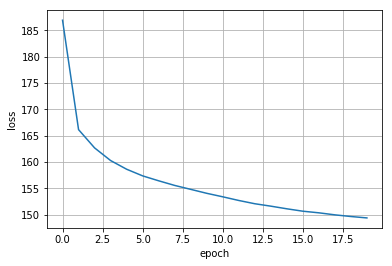

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
loss_list = np.load('{}/loss_list.npy'.format(out_dir))
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

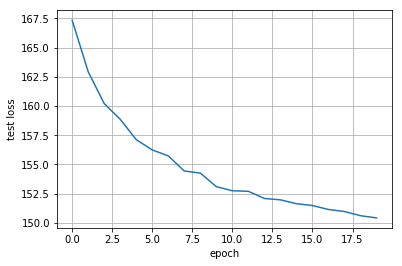

In [55]:
test_loss_list = np.load('{}/test_loss_list.npy'.format(out_dir))
plt.plot(test_loss_list)
plt.xlabel('epoch')
plt.ylabel('test loss')
plt.grid()

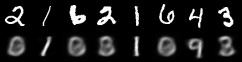

In [60]:
from IPython.display import Image
Image('result/VAE/reconstruction_0.png')

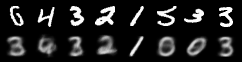

In [57]:
Image('result/VAE/reconstruction_10.png')

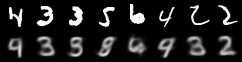

In [58]:
Image('result/VAE/reconstruction_20.png')

In [62]:
model.load_state_dict(torch.load('{}/vae.pth'.format(out_dir),
                                 map_location=lambda storage,
                                 loc: storage))
test_dataset = datasets.MNIST('./data', download=True, train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)
images, labels = iter(test_loader).next()
images = images.view(10000, -1)

# 784次元ベクトルを2次元ベクトルにencode
z = model.encode(Variable(images))
mu, logvar = z
mu, logvar = mu.data.numpy(), logvar.data.numpy()
print(mu.shape, logvar.shape)

(10000, 2) (10000, 2)


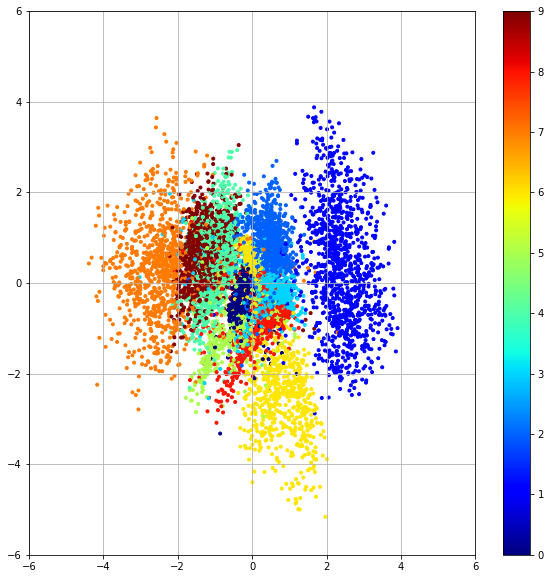

In [63]:
import pylab
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], marker='.', c=labels.numpy(), cmap=pylab.cm.jet)
plt.colorbar()
plt.xlim((-6, 6))
plt.ylim((-6, 6))
plt.grid()